# Generation of artifical sequence data based on Categorical Mixture Models

This notebook is an example of how to generate artifical sequences for the HLA-A gene using our approach based on categorical mixture models.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, write_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_HLA_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [8]:
inference_matrix.sum(axis=1).mean()

91.09704472843451

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

In [9]:
alphas = [0.1,1,10]
gammas = [0.05, 0.1, 0.5, 1]
reinits = 2
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler() for i in range(len(alphas) * len(gammas) * reinits)]
    i = 0
    for alpha in alphas:
        for gamma in gammas:
            for j in range(reinits):
                models[i].fit(inference_matrix, num_burn_in_steps = 20, num_steps=20, delta = 2, alpha = alpha, gamma = gamma)
                i+=1
%store models

Iteration: 1; Current clusters: 87; Likelihood: -2157314.472
Iteration: 2; Current clusters: 65; Likelihood: -2152778.341
Iteration: 3; Current clusters: 56; Likelihood: -2151749.158
Iteration: 4; Current clusters: 51; Likelihood: -2151124.477
Iteration: 5; Current clusters: 50; Likelihood: -2150769.396
Iteration: 6; Current clusters: 48; Likelihood: -2150642.212
Iteration: 7; Current clusters: 46; Likelihood: -2150384.056
Iteration: 8; Current clusters: 45; Likelihood: -2150354.268
Iteration: 9; Current clusters: 43; Likelihood: -2150259.114
Iteration: 10; Current clusters: 42; Likelihood: -2150092.663
Iteration: 11; Current clusters: 41; Likelihood: -2149933.248
Iteration: 12; Current clusters: 41; Likelihood: -2149966.593
Iteration: 13; Current clusters: 40; Likelihood: -2149920.252
Iteration: 14; Current clusters: 40; Likelihood: -2150002.666
Iteration: 15; Current clusters: 39; Likelihood: -2149826.323
Iteration: 16; Current clusters: 39; Likelihood: -2149865.650
Iteration: 17; Cu

Iteration: 17; Current clusters: 26; Likelihood: -2154247.144
Iteration: 18; Current clusters: 26; Likelihood: -2154326.926
Iteration: 19; Current clusters: 26; Likelihood: -2154275.516
Iteration: 20; Current clusters: 26; Likelihood: -2154194.432
Iteration: 21; Current clusters: 26; Likelihood: -2154233.556
Iteration: 22; Current clusters: 26; Likelihood: -2154261.824
Iteration: 23; Current clusters: 26; Likelihood: -2154339.501
Iteration: 24; Current clusters: 26; Likelihood: -2154226.150
Iteration: 25; Current clusters: 26; Likelihood: -2154180.399
Iteration: 26; Current clusters: 26; Likelihood: -2154251.875
Iteration: 27; Current clusters: 26; Likelihood: -2154284.734
Iteration: 28; Current clusters: 26; Likelihood: -2154232.649
Iteration: 29; Current clusters: 26; Likelihood: -2154282.542
Iteration: 30; Current clusters: 25; Likelihood: -2154225.184
Iteration: 31; Current clusters: 25; Likelihood: -2154230.990
Iteration: 32; Current clusters: 25; Likelihood: -2154277.850
Iteratio

Iteration: 27; Current clusters: 5; Likelihood: -2277081.894
Iteration: 28; Current clusters: 5; Likelihood: -2277069.864
Iteration: 29; Current clusters: 5; Likelihood: -2277060.510
Iteration: 30; Current clusters: 6; Likelihood: -2277055.624
Iteration: 31; Current clusters: 5; Likelihood: -2277106.278
Iteration: 32; Current clusters: 5; Likelihood: -2277150.849
Iteration: 33; Current clusters: 5; Likelihood: -2277118.493
Iteration: 34; Current clusters: 5; Likelihood: -2277074.261
Iteration: 35; Current clusters: 5; Likelihood: -2277174.034
Iteration: 1; Current clusters: 79; Likelihood: -2158506.612
Iteration: 2; Current clusters: 58; Likelihood: -2155085.194
Iteration: 3; Current clusters: 51; Likelihood: -2153528.344
Iteration: 4; Current clusters: 49; Likelihood: -2152041.289
Iteration: 5; Current clusters: 43; Likelihood: -2151329.541
Iteration: 6; Current clusters: 43; Likelihood: -2151281.137
Iteration: 7; Current clusters: 40; Likelihood: -2151172.874
Iteration: 8; Current cl

Iteration: 12; Current clusters: 30; Likelihood: -2152508.182
Iteration: 13; Current clusters: 30; Likelihood: -2152473.532
Iteration: 14; Current clusters: 30; Likelihood: -2152369.004
Iteration: 15; Current clusters: 30; Likelihood: -2152407.456
Iteration: 16; Current clusters: 31; Likelihood: -2152430.232
Iteration: 17; Current clusters: 30; Likelihood: -2152457.277
Iteration: 18; Current clusters: 30; Likelihood: -2152310.484
Iteration: 19; Current clusters: 30; Likelihood: -2152395.183
Iteration: 20; Current clusters: 30; Likelihood: -2152413.166
Iteration: 21; Current clusters: 30; Likelihood: -2152391.197
Iteration: 22; Current clusters: 30; Likelihood: -2152269.945
Iteration: 23; Current clusters: 30; Likelihood: -2152325.216
Iteration: 24; Current clusters: 30; Likelihood: -2152389.431
Iteration: 25; Current clusters: 30; Likelihood: -2152392.865
Iteration: 26; Current clusters: 31; Likelihood: -2152386.301
Iteration: 27; Current clusters: 30; Likelihood: -2152325.289
Iteratio

Iteration: 39; Current clusters: 8; Likelihood: -2205432.859
Iteration: 40; Current clusters: 8; Likelihood: -2205336.317
Iteration: 1; Current clusters: 11; Likelihood: -2214612.117
Iteration: 2; Current clusters: 8; Likelihood: -2207733.634
Iteration: 3; Current clusters: 8; Likelihood: -2206308.289
Iteration: 4; Current clusters: 9; Likelihood: -2206368.372
Iteration: 5; Current clusters: 8; Likelihood: -2206293.140
Iteration: 6; Current clusters: 7; Likelihood: -2206226.720
Iteration: 7; Current clusters: 7; Likelihood: -2206346.369
Iteration: 8; Current clusters: 7; Likelihood: -2206219.013
Iteration: 9; Current clusters: 8; Likelihood: -2206176.144
Iteration: 10; Current clusters: 8; Likelihood: -2206228.558
Iteration: 11; Current clusters: 8; Likelihood: -2206175.831
Iteration: 12; Current clusters: 7; Likelihood: -2206274.852
Iteration: 13; Current clusters: 7; Likelihood: -2206280.796
Iteration: 14; Current clusters: 7; Likelihood: -2206201.388
Iteration: 15; Current clusters:

Iteration: 26; Current clusters: 33; Likelihood: -2152164.975
Iteration: 27; Current clusters: 32; Likelihood: -2152082.988
Iteration: 28; Current clusters: 33; Likelihood: -2152085.230
Iteration: 29; Current clusters: 31; Likelihood: -2152022.563
Iteration: 30; Current clusters: 33; Likelihood: -2151987.463
Iteration: 31; Current clusters: 32; Likelihood: -2151917.070
Iteration: 32; Current clusters: 32; Likelihood: -2151979.581
Iteration: 33; Current clusters: 33; Likelihood: -2151971.953
Iteration: 34; Current clusters: 32; Likelihood: -2151837.246
Iteration: 35; Current clusters: 32; Likelihood: -2151806.811
Iteration: 36; Current clusters: 33; Likelihood: -2151764.751
Iteration: 37; Current clusters: 33; Likelihood: -2151758.152
Iteration: 38; Current clusters: 33; Likelihood: -2151732.686
Iteration: 39; Current clusters: 32; Likelihood: -2151764.867
Iteration: 40; Current clusters: 31; Likelihood: -2151827.071
Iteration: 1; Current clusters: 46; Likelihood: -2161256.445
Iteration

Iteration: 20; Current clusters: 11; Likelihood: -2188036.404
Iteration: 21; Current clusters: 11; Likelihood: -2188150.912
Iteration: 22; Current clusters: 9; Likelihood: -2188153.356
Iteration: 23; Current clusters: 11; Likelihood: -2187978.186
Iteration: 24; Current clusters: 11; Likelihood: -2188120.971
Iteration: 25; Current clusters: 9; Likelihood: -2188024.349
Iteration: 26; Current clusters: 10; Likelihood: -2188052.819
Iteration: 27; Current clusters: 11; Likelihood: -2188033.144
Iteration: 28; Current clusters: 9; Likelihood: -2188012.170
Iteration: 29; Current clusters: 10; Likelihood: -2188014.755
Iteration: 30; Current clusters: 9; Likelihood: -2188050.347
Iteration: 31; Current clusters: 11; Likelihood: -2188023.110
Iteration: 32; Current clusters: 11; Likelihood: -2188021.084
Iteration: 33; Current clusters: 13; Likelihood: -2188019.441
Iteration: 34; Current clusters: 12; Likelihood: -2187871.075
Iteration: 35; Current clusters: 10; Likelihood: -2188047.249
Iteration: 3

Model 0:


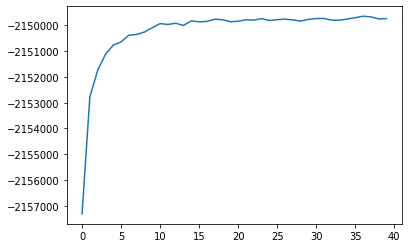

Model 1:


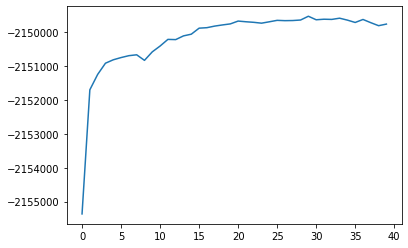

Model 2:


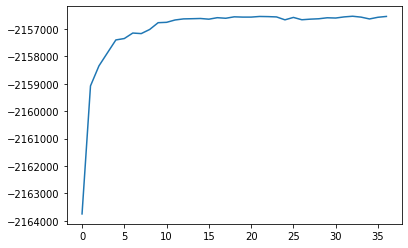

Model 3:


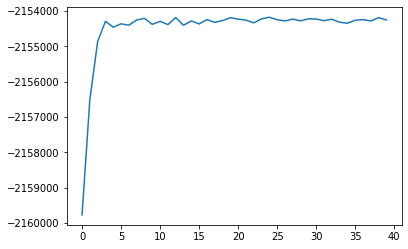

Model 4:


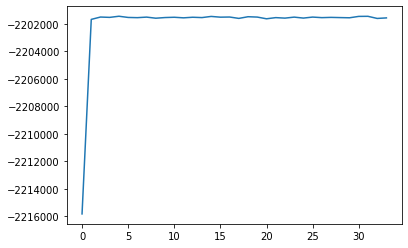

Model 5:


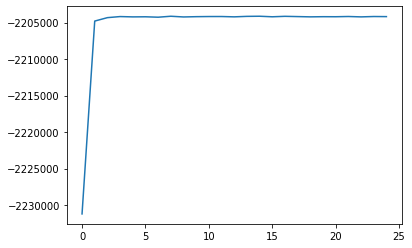

Model 6:


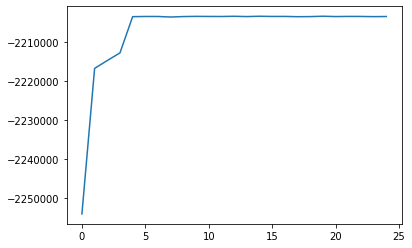

Model 7:


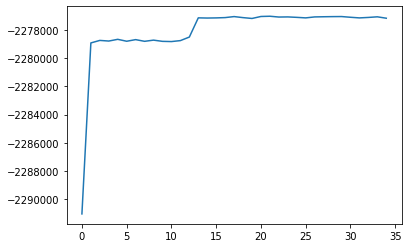

Model 8:


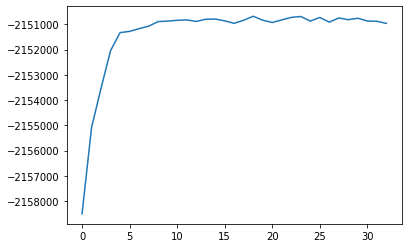

Model 9:


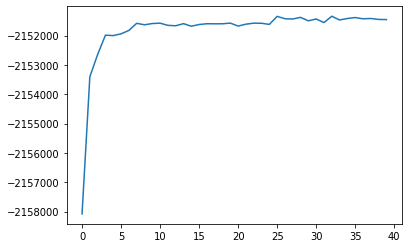

Model 10:


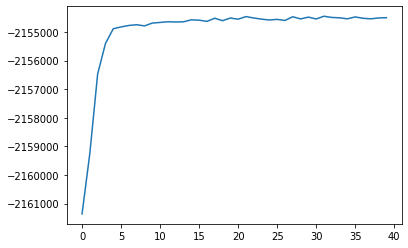

Model 11:


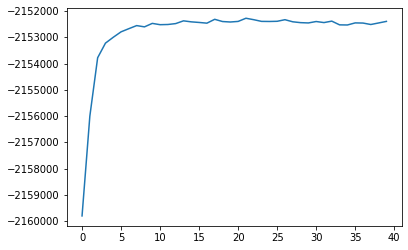

Model 12:


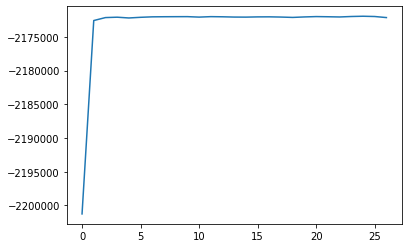

Model 13:


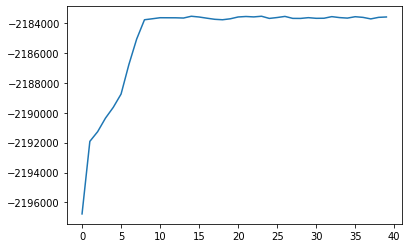

Model 14:


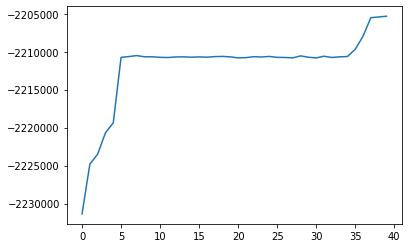

Model 15:


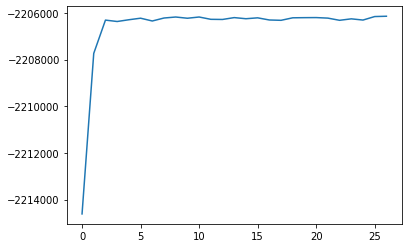

Model 16:


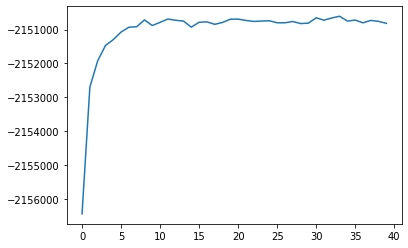

Model 17:


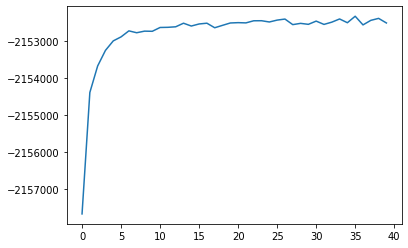

Model 18:


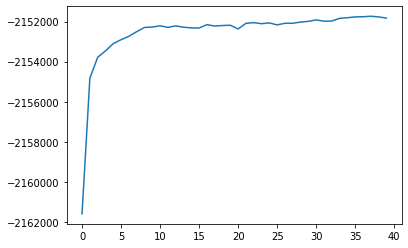

Model 19:


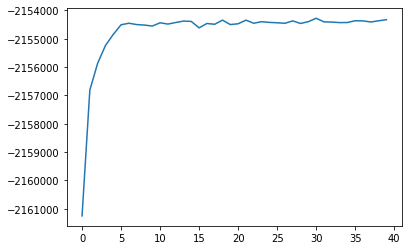

Model 20:


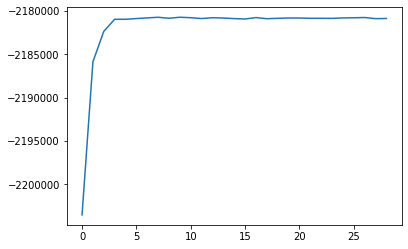

Model 21:


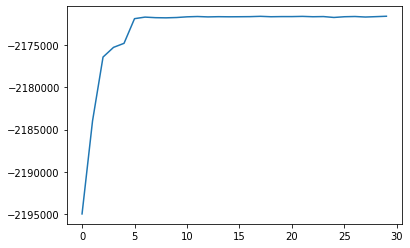

Model 22:


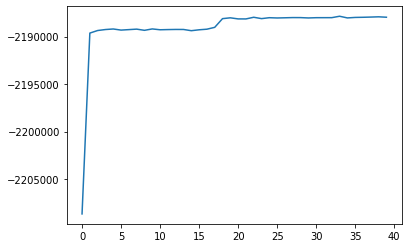

Model 23:


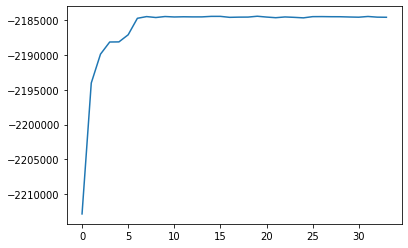

In [10]:
for i, model in enumerate(models):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [11]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), models))
AIC = sorted(zip(values, range(len(values)), list(map(lambda x: x.K_seen, models))), key = lambda x: x[0])
for a in AIC:
    print("AIC: {} Model: {} Cluster {}".format(a[0], a[1], a[2]))

AIC: 4330413.705689743 Model: 3 Cluster 25
AIC: 4330810.142698683 Model: 18 Cluster 31
AIC: 4330896.561947539 Model: 10 Cluster 25
AIC: 4331059.1123225605 Model: 11 Cluster 30
AIC: 4331944.642391485 Model: 1 Cluster 37
AIC: 4332768.294675967 Model: 0 Cluster 38
AIC: 4333463.135158793 Model: 8 Cluster 36
AIC: 4333573.19210028 Model: 9 Cluster 35
AIC: 4334065.3759903535 Model: 19 Cluster 29
AIC: 4334117.911784013 Model: 2 Cluster 24
AIC: 4334915.027345925 Model: 16 Cluster 38
AIC: 4336549.11495585 Model: 17 Cluster 36
AIC: 4353011.609445159 Model: 12 Cluster 10
AIC: 4355519.356670088 Model: 21 Cluster 14
AIC: 4373138.080284587 Model: 20 Cluster 13
AIC: 4378560.583252141 Model: 13 Cluster 13
AIC: 4379710.657265897 Model: 23 Cluster 12
AIC: 4384709.434377809 Model: 22 Cluster 10
AIC: 4411868.858798095 Model: 4 Cluster 10
AIC: 4414061.916406815 Model: 6 Cluster 8
AIC: 4417145.617433032 Model: 5 Cluster 10
AIC: 4417680.63364827 Model: 14 Cluster 8
AIC: 4418418.018466166 Model: 15 Cluster 7
A

In [12]:
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

Chose model 3.


In [13]:
# may set manually
#best_idx = 0

## Section 4: Model analysis

In this section we explore our model a little bit.

In [14]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.34239843, 0.53971578])

=> Over 50% of the variation can be explained by the first two principle components.

In [15]:
inds = [0]*len(inference_matrix)
for ind, pos in individual_map.items():
    inds[2*pos] = ind
    inds[2*pos+1] = ind
# Ploting for superpopulations
populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Here we plot the PCA for all individuals colored first by superpopulation, then by cluster assignment

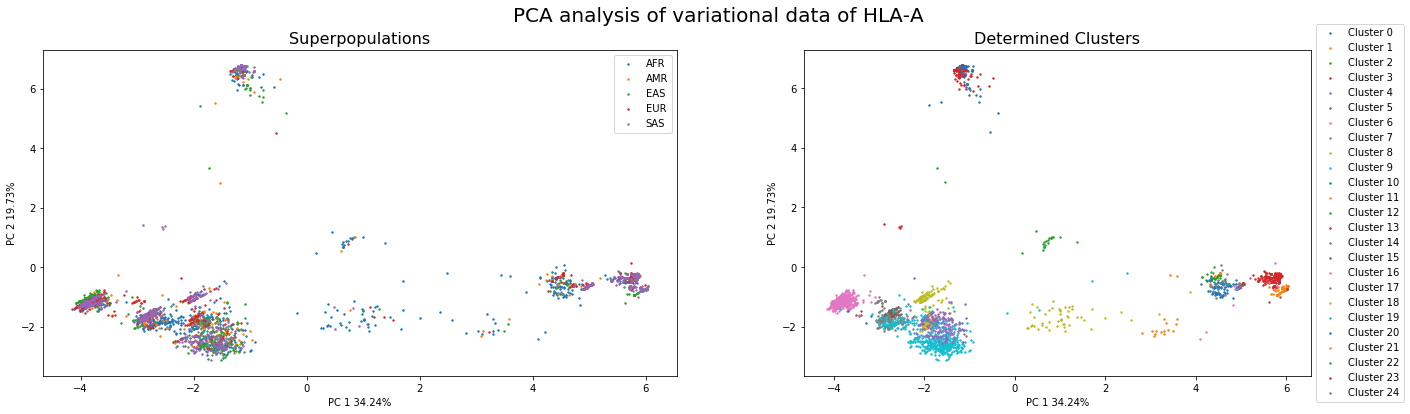

In [16]:
fig, ax = plt.subplots(1,2,figsize = (25,6))
variance = pca.explained_variance_ratio_
fig.suptitle("PCA analysis of variational data of HLA-A", fontsize=20)


for i in range(models[best_idx].K_seen):
    ax[0].set_title("Superpopulations", fontsize=16)
    ax[0].scatter(principalComponents[pops == i,0], principalComponents[pops == i,1], s=2)
    ax[0].set_xlabel("PC 1 " + str(round(variance[0]*100, 2)) + "%")
    ax[0].set_ylabel("PC 2 " + str(round(variance[1]*100, 2)) + "%")
ax[0].legend(populations)
for i in range(models[best_idx].K_seen):
    ax[1].set_title("Determined Clusters", fontsize=16)
    ax[1].scatter(principalComponents[models[best_idx].Z == i,0], principalComponents[models[best_idx].Z == i,1], s=2)
    ax[1].set_xlabel("PC 1 " + str(round(variance[0]*100, 2)) + "%")
    ax[1].set_ylabel("PC 2 " + str(round(variance[1]*100, 2)) + "%")

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax[1].legend(["Cluster " + str(i) for i in range(models[best_idx].K_seen)], loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("pca_HLA.pdf")

In [17]:
pops_per_cluster = np.array([np.histogram(pops[models[best_idx].Z == i], bins=5)[0] for i in range(models[best_idx].K_seen)])
#pops_per_cluster = pops_per_cluster / pops_per_cluster.sum(axis=0)
df = pd.DataFrame(dict(zip(["AFR", "AMR", "EAS", "EUR", "SAS"], pops_per_cluster.T)))
df.index = ["Cluster " + str(i) for i in range(len(models[best_idx].theta))]

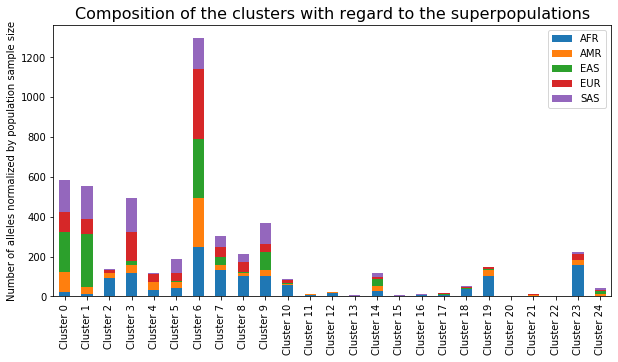

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Composition of the clusters with regard to the superpopulations", fontsize=16)
ax.set_ylabel("Number of alleles normalized by population sample size")
df.plot(kind="bar", stacked=True, ax=ax)
fig.savefig("pop_per_cluster.pdf")


In the following we plot the probability for each variant for each of the clusters. We can see that each cluster has a distinct pattern of variants.

In [1]:
df2 = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(models[best_idx].theta))], list(models[best_idx].theta))))


NameError: name 'pd' is not defined

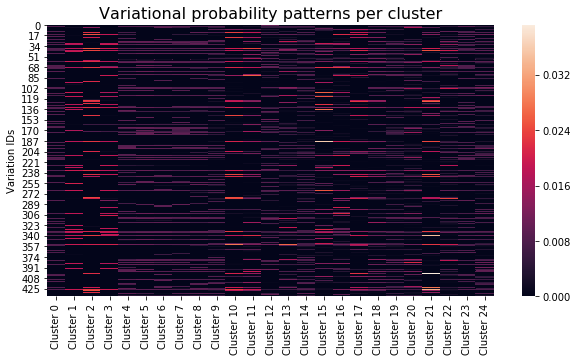

In [20]:
id_map = dict(map(lambda x: reversed(x),variation_map.items()))
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Variational probability patterns per cluster", fontsize=16)
ax = sns.heatmap(df2)
ax.set_ylabel("Variation IDs")
fig.savefig("HLA_patterns.pdf")

## Section 5: Sequence Generation

The following builds a sequence generator from the parameters which were determined during model training.

In [40]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(models[best_idx].Z, models[best_idx].theta, inference_matrix, variant_ranges, variation_map)

We can then sample a set of indices which can be mapped to variant ids.

In [41]:
sample = mm.sample_variations()

We can compare the samples to the respective cluster. Here the choice of cluster is equally distributed. In the sampling without specified cluster it is determined based on infered paramters, i.e. in reality some clusters might be much more rare than it may seem here.

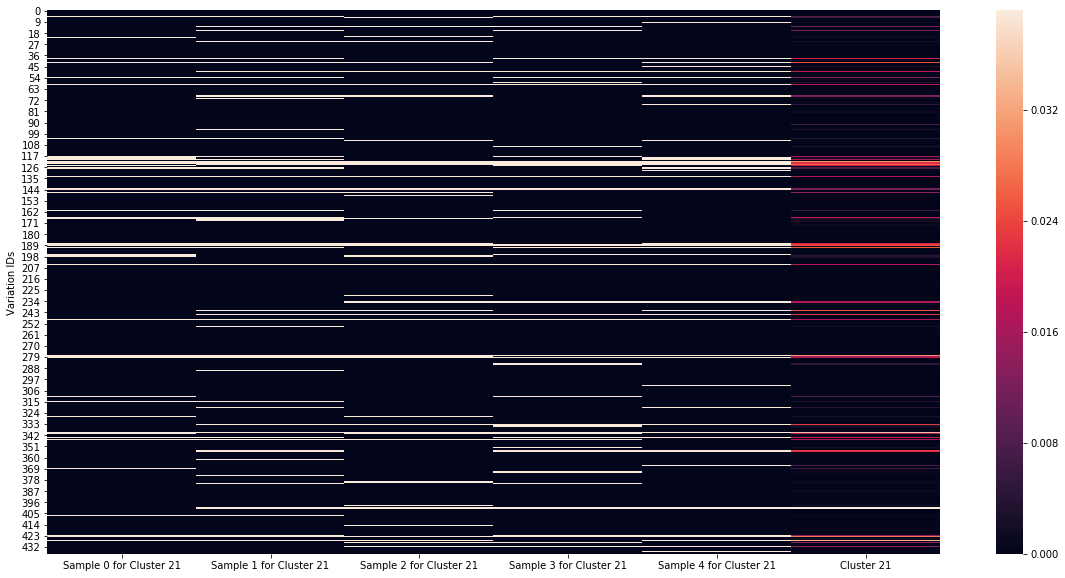

In [42]:
number_of_samples = 5
samples = []
descriptions = []
k = np.random.choice(range(int(max(models[best_idx].Z))))
theta = models[best_idx].theta[k]
indicator_value = theta.max()
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(theta))
    characteristic_vector[mm.sample_variations(k)] = indicator_value
    samples.append(characteristic_vector)
    descriptions.append("Sample {} for Cluster {}".format(i, k))
samples.append(theta)
descriptions.append("Cluster {}".format(k))
df = pd.DataFrame(dict(zip(descriptions, samples)))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)
ax.set_ylabel("Variation IDs")
fig.savefig("samples_example.pdf")
    

According to the sampled variations and using the reference sequence we can stitch the respective generated sequences together and write them to a fasta file (the sequences will also be reported in the notebook). The fasta file will be named _Generated Sequences.fasta_ and should be created in the location of this notebook.

In [43]:
mm.generate_sequences(5, variation_map, data_manager, filename ="Generated Sequences", **allele_args)

For comparison we also write the reference sequence to a seperate fasta file.

In [46]:
write_sequences("Reference Sequence.fasta", [">{}".format(header)], [seq])